# Batch anomaly detection
Link [Batch anomaly detection](https://github.com/kLabUM/rrcf/blob/master/docs/batch.md)

## Import modules and create sample data

In [1]:
import numpy as np
import pandas as pd
import rrcf

# Set sample parameters
np.random.seed(0)
n = 2010
d = 3

# Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)

## Construct a random forest

In [2]:
# Set forest parameters
num_trees = 100
tree_size = 256
sample_size_range = (n // tree_size, tree_size)

# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly
    ixs = np.random.choice(n, size=sample_size_range,
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix)
             for ix in ixs]
    forest.extend(trees)

## Compute anomaly score

In [3]:
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf)
                       for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

## Plot result

Text(0.5, 0.92, 'CoDisp above 99.5th percentile')

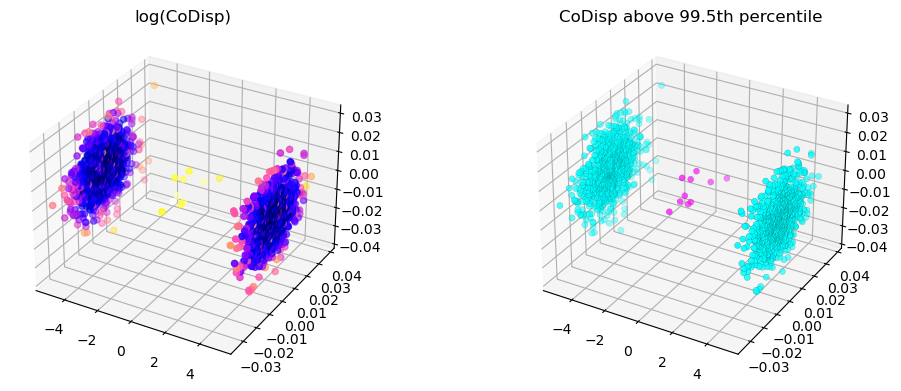

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import colors

threshold = avg_codisp.nlargest(n=10).min()

fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                c=np.log(avg_codisp.sort_index().values),
                cmap='gnuplot2')
plt.title('log(CoDisp)')
ax = fig.add_subplot(122, projection='3d')
sc = ax.scatter(X[:,0], X[:,1], X[:,2],
                linewidths=0.1, edgecolors='k',
                c=(avg_codisp >= threshold).astype(float),
                cmap='cool')
plt.title('CoDisp above 99.5th percentile')